In [1]:
from instant_ack import *

%load_ext autoreload
%autoreload 2

2024-09-11 16:03:03.152 | INFO     | instant_ack.config:<module>:11 - PROJ_ROOT path is: /data/instant-ack


# Load data

In [2]:
df = (
    cv.load_data("qlog", skip_missing=True)
    .filter(
        pl.col("name") == "transport:packet_received",
        # When we observe the first stream frame from the server the first byte has been received
        pl.col("frame_frame_type").str.contains("stream"),
    )
    .sort(["file", "time_since_first_ms"])
    .with_row_index("idx")
    .filter(
        # Get first stream frame
        pl.col("idx")
        == (pl.col("idx").min().over("file"))
    )
)

In [3]:
df_first = (
    cv.load_data("qlog", skip_missing=True)
    .filter(
        pl.col("name") == "transport:packet_received",
        # When we observe the first stream frame from the server the first byte has been received
        pl.col("frame_frame_type").str.contains("ack"),
    )
    .sort(["file", "time_since_first_ms"])
    .with_row_index("idx")
    .filter(
        # Get first stream frame
        pl.col("idx")
        == (pl.col("idx").min().over("file"))
    )
)

In [4]:
t = df.group_by(["server_group", "client", "scenario"]).agg(
    pl.col("time_since_first_ms").mean().alias("Mean"),
    pl.col("time_since_first_ms").std().alias("\\sigma"),
)
t.collect()

server_group,client,scenario,Mean,\sigma
str,str,str,f64,f64
"""IACK""","""quiche""","""http3cdroplist""",327.777126,418.458685
"""IACK""","""aioquic""","""http3cdroplist""",280.526415,289.624316
"""WFC""","""quiche""","""goodputdroplist""",577.029598,826.049129
"""WFC""","""aioquic""","""goodputdroplist""",390.060785,418.609044
"""IACK""","""aioquic""","""http3c""",116.821393,101.119327
…,…,…,…,…
"""IACK""","""mvfst""","""http3cdroplist""",235.938714,210.456651
"""WFC""","""neqo""","""goodput""",218.07383,198.240177
"""IACK""","""picoquic""","""http3cdroplist""",234.969777,208.190847


In [5]:
required_cols = [
    "client",
    "server_group",
    "scenario",
    "time_since_first_ms",
    "meta_name",
    "meta_pair",
    "meta_drop-to-client",
    "meta_drop-to-server",
    "rtt",
    "folder",
    "file",
]

# Plots

### Certificate >= 3x client data + large delta t

In [6]:
cert = cv.get_measurement(df, "certificate").select(required_cols).collect()
ignore_list = []
_ = v.validate(cert, ignore=ignore_list)

All groups of ['folder', 'scenario'] had 100 unique files. All OK!


### TTFB with Δ𝑡 = 200 𝑚𝑠: Section 4.1, Figure 5

All groups of ['client', 'server_group'] had 100 unique files. All OK!


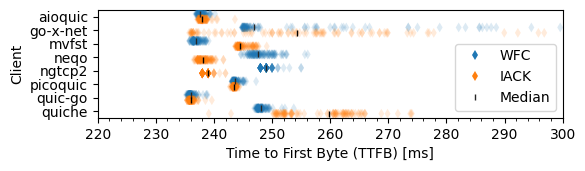

In [7]:
plot.strip(
    cert.filter(
        pl.col("scenario") == "goodput",
    ),
    legend_pos="lower right",
    dest="interop-runner/str_ttfb_large_cert_200ms_delay_no_loss_goodput",
    xlim=(220, 300),
    xMajorLocator=ticker.MultipleLocator(10),
    xMinorLocator=ticker.MultipleLocator(2),
    legend_ncol=1,
)
plt.show()
plt.close()

All groups of ['client', 'server_group'] had 100 unique files. All OK!


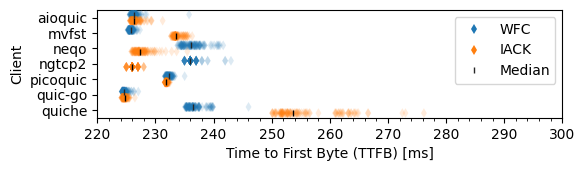

In [8]:
fig, ax = vh.fig_ax()
plot.strip(
    cert.filter(
        pl.col("scenario") == "http3c",
    ),
    dest="interop-runner/str_ttfb_large_cert_200ms_delay_no_loss_http3",
    legend=True,
    legend_ncol=1,
    legend_pos="upper right",
    xlim=(220, 300),
    fig=fig,
    ax=ax,
    xMajorLocator=ticker.MultipleLocator(10),
    xMinorLocator=ticker.MultipleLocator(2),
)
plt.show()
plt.close()

### IACK vs WFC TTFB statistics: Section 4.1

In [9]:
with pl.Config(tbl_rows=16):
    display(cv.get_pto_improvement(cert, group=["scenario", "client", "server_group"]))

scenario,client,IACK,WFC,pto_improvement,improvement
str,str,f64,f64,f64,f64
"""goodput""","""aioquic""",237.991,237.6925,-0.8955,-0.2985
"""goodput""","""go-x-net""",254.26,246.8285,-22.2945,-7.4315
"""goodput""","""mvfst""",244.498,236.939,-22.677,-7.559
"""goodput""","""neqo""",238.0975,247.652,28.6635,9.5545
"""goodput""","""ngtcp2""",239.0,249.0,30.0,10.0
"""goodput""","""picoquic""",243.482,243.6135,0.3945,0.1315
"""goodput""","""quic-go""",236.061,235.9755,-0.2565,-0.0855
"""goodput""","""quiche""",259.746,248.0515,-35.0835,-11.6945
"""http3c""","""aioquic""",226.37,226.265,-0.315,-0.105


In [10]:
cert_rtt = cv.get_measurement(df_first, "certificate").select(required_cols).collect()
_ = v.validate(cert_rtt, ignore=ignore_list)

All groups of ['folder', 'scenario'] had 100 unique files. All OK!


In [11]:
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(cert_rtt, group=["scenario", "client", "server_group"])
    )

scenario,client,WFC,IACK,pto_improvement,improvement
str,str,f64,f64,f64,f64
"""goodput""","""aioquic""",220.903,16.914,611.967,203.989
"""goodput""","""go-x-net""",220.9655,26.0675,584.694,194.898
"""goodput""","""mvfst""",219.844,16.3345,610.5285,203.5095
"""goodput""","""neqo""",222.022,16.901,615.363,205.121
"""goodput""","""ngtcp2""",221.0,17.0,612.0,204.0
"""goodput""","""picoquic""",219.904,16.3135,610.7715,203.5905
"""goodput""","""quic-go""",220.3845,16.57,611.4435,203.8145
"""goodput""","""quiche""",220.271,16.8985,610.1175,203.3725
"""http3c""","""aioquic""",220.957,17.118,611.517,203.839


## Loss of packets 2 and 3 (IACK) and packets 2 (WFC)
i.e. **r**emaining **f**irst **s**erver **f**light (rfsf)

In [12]:
rfsf = (
    cv.get_measurement(df, "remaining_first_server_flight")
    .select(required_cols)
    .collect()
)
ignore_list = [
    # quiche: Duplicate retire connection ID
    "/data/instant-ack/data/raw/interop-runner/quiche/logs_delay=50.0ms,c=quiche,drop-to-server=,file_size=10KB,name=tcdgroup2 2_3,pair=1,delay-first-packet=0,drop-to-client=2_2024-08-08T21:55:46",
    "/data/instant-ack/data/raw/interop-runner/quiche/logs_delay=150.0ms,c=quiche,drop-to-server=,file_size=10KB,name=tcdgroup2 2_3,pair=1,instant-ack-delay=0,instant-ack=1,drop-to-client=2_3_2024-08-09T05:38:25",
]
_ = v.validate(rfsf, ignore=ignore_list)

All groups of ['folder', 'scenario'] had 100 unique files. All OK!


### TTFB under loss of remaining first server flight: Section 4.2, Figure 6

All groups of ['client', 'server_group'] had 100 unique files. All OK!


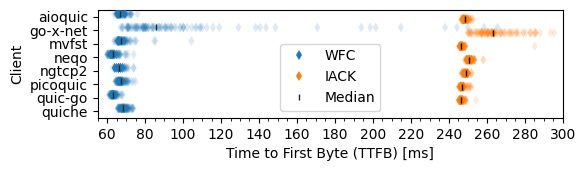

In [13]:
plot.strip(
    rfsf.filter(
        pl.col("scenario") == "goodputdroplist",
        pl.col("rtt") == 9,
    ),
    dest="interop-runner/str_ttfb_remaining_first_server_flight_goodput",
    legend_pos="lower center",
    xMajorLocator=ticker.MultipleLocator(20),
    xMinorLocator=ticker.MultipleLocator(5),
    xlim=(55, 300),
    legend_ncol=1,
)
plt.show()
plt.close()
# quiche still suffers from duplicate connection ID retirement

All groups of ['client', 'server_group'] had 100 unique files. All OK!


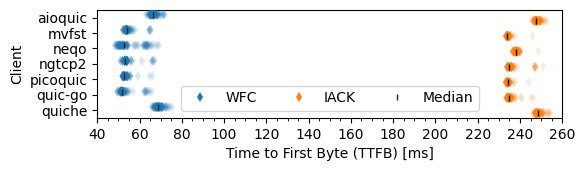

In [14]:
plot.strip(
    rfsf.filter(
        pl.col("scenario") == "http3cdroplist",
        pl.col("rtt") == 9,
    ),
    dest="interop-runner/str_ttfb_remaining_first_server_flight_http3",
    legend_pos="lower center",
    xMajorLocator=ticker.MultipleLocator(20),
    xMinorLocator=ticker.MultipleLocator(5),
    xlim=(40, 260),
)
plt.show()
plt.close()

### IACK vs WFC TTFB statistics: Section 4.2

In [15]:
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(
            rfsf.filter(
                pl.col("scenario") == "goodputdroplist",
                pl.col("rtt") == 9,
            ),
            group=["scenario", "client", "server_group"],
        )
    )

scenario,client,WFC,IACK,pto_improvement,improvement
str,str,f64,f64,f64,f64
"""goodputdroplist""","""aioquic""",66.7585,248.324,-544.6965,-181.5655
"""goodputdroplist""","""go-x-net""",85.9155,263.049,-531.4005,-177.1335
"""goodputdroplist""","""mvfst""",67.1365,246.656,-538.5585,-179.5195
"""goodputdroplist""","""neqo""",62.9145,250.782,-563.6025,-187.8675
"""goodputdroplist""","""ngtcp2""",66.0,249.0,-549.0,-183.0
"""goodputdroplist""","""picoquic""",67.056,246.7475,-539.0745,-179.6915
"""goodputdroplist""","""quic-go""",63.0775,246.546,-550.4055,-183.4685
"""goodputdroplist""","""quiche""",68.609,null,null,null


In [16]:
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(
            rfsf.filter(
                pl.col("scenario") == "goodputdroplist",
                pl.col("rtt") == 9,
            ),
            group=["scenario", "server_group"],
        )
    )

scenario,WFC,IACK,pto_improvement,improvement
str,f64,f64,f64,f64
"""goodputdroplist""",66.7945,248.1885,-544.182,-181.394


In [17]:
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(
            rfsf.filter(
                pl.col("scenario") == "http3cdroplist",
                pl.col("rtt") == 9,
            ),
            group=["scenario", "client", "server_group"],
        )
    )

scenario,client,WFC,IACK,pto_improvement,improvement
str,str,f64,f64,f64,f64
"""http3cdroplist""","""aioquic""",66.3765,247.724,-544.0425,-181.3475
"""http3cdroplist""","""mvfst""",53.8925,234.046,-540.4605,-180.1535
"""http3cdroplist""","""neqo""",52.6555,238.126,-556.4115,-185.4705
"""http3cdroplist""","""ngtcp2""",53.0,235.0,-546.0,-182.0
"""http3cdroplist""","""picoquic""",52.7575,234.247,-544.4685,-181.4895
"""http3cdroplist""","""quic-go""",51.896,234.8445,-548.8455,-182.9485
"""http3cdroplist""","""quiche""",68.957,248.3015,-538.0335,-179.3445


In [18]:
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(
            rfsf.filter(
                pl.col("scenario") == "http3cdroplist",
                pl.col("rtt") == 9,
            ),
            group=["scenario", "server_group"],
        )
    )

scenario,WFC,IACK,pto_improvement,improvement
str,f64,f64,f64,f64
"""http3cdroplist""",54.0,236.0,-546.0,-182.0


### IACK vs WFC First RTT Improvement

In [19]:
rfsf_rtt = (
    cv.get_measurement(df_first, "remaining_first_server_flight")
    .select(required_cols)
    .collect()
)
_ = v.validate(rfsf_rtt, ignore=ignore_list)

All groups of ['folder', 'scenario'] had 100 unique files. All OK!


In [20]:
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(
            rfsf_rtt.filter(pl.col("scenario").str.contains("droplist")),
            group=["scenario", "client", "server_group"],
        )
    )

scenario,client,IACK,WFC,pto_improvement,improvement
str,str,f64,f64,f64,f64
"""goodputdroplist""","""aioquic""",27.47,30.8555,10.1565,3.3855
"""goodputdroplist""","""go-x-net""",27.7835,34.7095,20.778,6.926
"""goodputdroplist""","""mvfst""",27.371,30.947,10.728,3.576
"""goodputdroplist""","""neqo""",27.73,31.5405,11.4315,3.8105
"""goodputdroplist""","""ngtcp2""",28.0,31.0,9.0,3.0
"""goodputdroplist""","""picoquic""",27.433,30.9645,10.5945,3.5315
"""goodputdroplist""","""quic-go""",27.6095,33.3755,17.298,5.766
"""goodputdroplist""","""quiche""",308.5435,20.075,-865.4055,-288.4685
"""http3cdroplist""","""aioquic""",27.6455,31.5605,11.745,3.915


### Loss of remaining first server flight at all RTTs: Appendix D, Figure 10

In [21]:
rfsf_goodput = rfsf.filter(pl.col("scenario") == "goodputdroplist").sort("rtt")

All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
NOT all groups of ['client', 'server_group'] had 100 unique files. You may want to verify what happened to the subsequent folders


client,server_group,file_n,folder_unique,folder_unique_len
str,str,u32,list[str],u32
"""quiche""","""WFC""",1,"[""/data/instant-ack/data/raw/interop-runner/quiche/logs_delay=50.0ms,c=quiche,drop-to-server=,file_size=10KB,name=tcdgroup2 2_3,pair=1,delay-first-packet=0,drop-to-client=2_2024-08-08T21:55:46""]",1


NOT all groups of ['client', 'server_group'] had 100 unique files. You may want to verify what happened to the subsequent folders


client,server_group,file_n,folder_unique,folder_unique_len
str,str,u32,list[str],u32
"""quiche""","""IACK""",1,"[""/data/instant-ack/data/raw/interop-runner/quiche/logs_delay=150.0ms,c=quiche,drop-to-server=,file_size=10KB,name=tcdgroup2 2_3,pair=1,instant-ack-delay=0,instant-ack=1,drop-to-client=2_3_2024-08-09T05:38:25""]",1


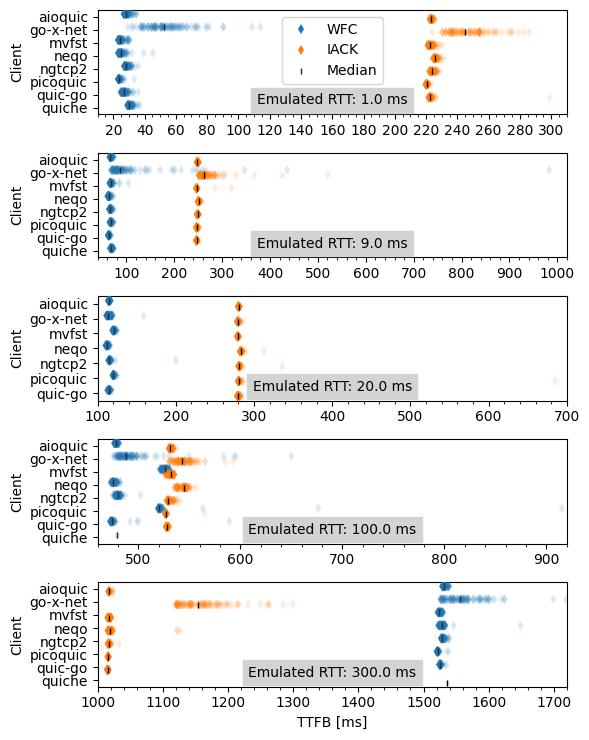

In [22]:
plot.multi(
    rfsf_goodput,
    group_by="rtt",
    figsize=(6, 1.5 * 5),
    x="time_since_first_ms",
    y="client",
    dest="interop-runner/str_rfsf_ttfb_all_latencies_goodputdroplist",
    sharex=False,
    major=[20, 100, 100, 100, 100],
    minor=[5, 20, 20, 20, 20],
    xlim=[(10, 310), (40, 1020), (100, 700), (460, 920), (1000, 1720)],
    auto_scale_x=False,
)

In [23]:
rfsf_http3droplist = rfsf.filter(
    pl.col("scenario") == "http3cdroplist",
).select(required_cols)

All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!


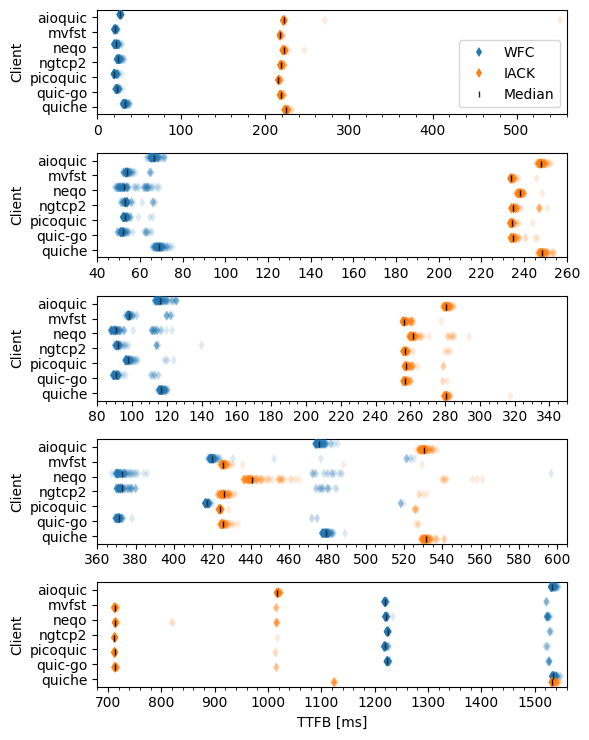

In [24]:
# needs y axis adaptation
plot.multi(
    rfsf_http3droplist.sort("rtt"),
    group_by="rtt",
    figsize=(6, 1.5 * 5),
    x="time_since_first_ms",
    y="client",
    dest="interop-runner/str_rfsf_ttfb_all_latencies_http3cdroplist",
    sharex=False,
    legend_pos="lower right",
    anc=None,
    major=[100, 20, 20, 20, 100],
    minor=[20, 5, 5, 5, 20],
    xlim=[(0, 560), (40, 260), (80, 350), (360, 605), (680, 1560)],
    auto_scale_x=False,
)

## Loss of second client flight

In [25]:
lscf = cv.get_measurement(df, "second_client_flight").select(required_cols).collect()
_ = v.validate(lscf)

NOT all groups of ['folder', 'scenario'] had 100 unique files. You may want to verify what happened to the subsequent folders


folder,scenario,file_n,folder_unique,folder_unique_len
str,str,u32,list[str],u32
"""/data/instant-ack/data/raw/int…","""goodput""",12,"[""/data/instant-ack/data/raw/interop-runner/go-x-net/logs_delay=50.0,c=go-x-net,drop-to-client=,drop-to-server=2_3_4,file_size=10KB,name=to_server_loss,instant-ack-delay=0,instant-ack=1_2024-08-17T18:32:47""]",1


### Loss of second client flight: Section 4.2, Figure 7

All groups of ['client', 'server_group'] had 100 unique files. All OK!


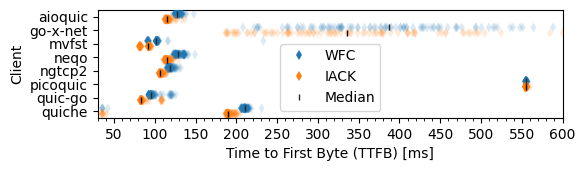

In [26]:
plot.strip(
    lscf.filter(pl.col("scenario") == "goodputdroplist", pl.col("rtt") == 9),
    dest="interop-runner/str_ttfb_lscf_goodput_9ms",
    legend_pos="lower center",
    legend_ncol=1,
    xMajorLocator=ticker.MultipleLocator(50),
    xMinorLocator=ticker.MultipleLocator(10),
    xlim=(30, 600),
)
plt.show()
plt.close()

### IACK vs WFC TTFB statistics: Section 4.2

In [27]:
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(
            lscf.filter(pl.col("scenario") == "goodputdroplist", pl.col("rtt") == 9),
            group=["scenario", "client", "server_group"],
        )
    )

scenario,client,WFC,IACK,pto_improvement,improvement
str,str,f64,f64,f64,f64
"""goodputdroplist""","""aioquic""",127.7515,115.066,38.0565,12.6855
"""goodputdroplist""","""go-x-net""",387.207,336.1335,153.2205,51.0735
"""goodputdroplist""","""mvfst""",102.01,91.271,32.217,10.739
"""goodputdroplist""","""neqo""",128.6825,114.4565,42.678,14.226
"""goodputdroplist""","""ngtcp2""",119.0,107.0,36.0,12.0
"""goodputdroplist""","""picoquic""",555.0575,554.7195,1.014,0.338
"""goodputdroplist""","""quic-go""",95.3215,83.4975,35.472,11.824
"""goodputdroplist""","""quiche""",210.4085,189.734,62.0235,20.6745


In [28]:
# Independent of RTT
with pl.Config(tbl_rows=16):
    display(
        cv.get_pto_improvement(
            lscf.filter(
                pl.col("scenario") == "goodputdroplist",
            ),
            group=["scenario", "client", "server_group"],
        ).sort("improvement")
    )

scenario,client,IACK,WFC,pto_improvement,improvement
str,str,f64,f64,f64,f64
"""goodputdroplist""","""picoquic""",599.8595,600.435,1.7265,0.5755
"""goodputdroplist""","""mvfst""",144.0365,154.112,30.2265,10.0755
"""goodputdroplist""","""aioquic""",167.3405,178.2725,32.796,10.932
"""goodputdroplist""","""quic-go""",139.0265,150.0975,33.213,11.071
"""goodputdroplist""","""ngtcp2""",183.0,194.5,34.5,11.5
"""goodputdroplist""","""neqo""",190.0825,202.286,36.6105,12.2035
"""goodputdroplist""","""quiche""",279.2045,302.0205,68.448,22.816
"""goodputdroplist""","""go-x-net""",414.4085,442.2915,83.649,27.883


In [29]:
lscf_goodput = lscf.filter(pl.col("scenario") == "goodputdroplist").sort("rtt")

### Loss of second client flight at all RTTs: Appendix D, Figure 11

All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!


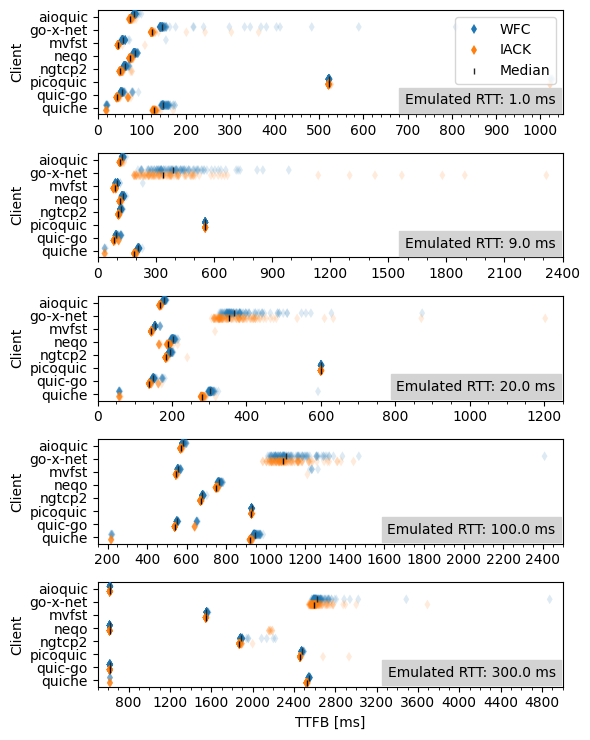

In [30]:
plot.multi(
    lscf_goodput,
    group_by="rtt",
    figsize=(6, 1.5 * 5),
    x="time_since_first_ms",
    y="client",
    dest="interop-runner/str_lscf_ttfb_all_latencies_goodputdroplist",
    sharex=False,
    anc_loc="lower right",
    legend_pos="upper right",
    major=[100, 300, 200, 200, 400],
    minor=[20, 100, 50, 50, 100],
    xlim=[(0, 1050), (0, 2400), (0, 1250), (150, 2500), (500, 5000)],
    auto_scale_x=False,
)

In [31]:
df_snd = (
    cv.load_data("qlog", skip_missing=True)
    .filter(
        pl.col("name") == "transport:packet_received",
        # When we observe the first stream frame from the server the first byte has been received
        pl.col("frame_frame_type").str.contains("stream"),
    )
    .sort(["file", "time_since_first_ms"])
    .with_row_index("idx")
    .filter(
        # Get second stream frame, first one is HTTP settings frame sent by server in HTTP3
        pl.col("idx").is_in(pl.col("idx").bottom_k(2).over("file"))
    )
    .filter(pl.col("idx") == pl.col("idx").max().over("file"))
)

lscf_snd = (
    cv.get_measurement(df_snd, "second_client_flight").select(required_cols).collect()
)
_ = v.validate(lscf_snd)
# We only look into droplist scenarios, below warning is safe to ignore

NOT all groups of ['folder', 'scenario'] had 100 unique files. You may want to verify what happened to the subsequent folders


folder,scenario,file_n,folder_unique,folder_unique_len
str,str,u32,list[str],u32
"""/data/instant-ack/data/raw/int…","""goodput""",12,"[""/data/instant-ack/data/raw/interop-runner/go-x-net/logs_delay=50.0,c=go-x-net,drop-to-client=,drop-to-server=2_3_4,file_size=10KB,name=to_server_loss,instant-ack-delay=0,instant-ack=1_2024-08-17T18:32:47""]",1


In [32]:
lscf_http3 = lscf_snd.filter(
    pl.col("scenario") == "http3cdroplist",
).sort("rtt")

All groups of ['client', 'server_group'] had 100 unique files. All OK!


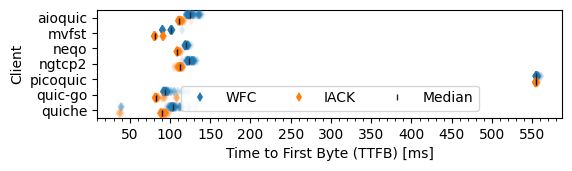

In [33]:
plot.strip(
    lscf_http3.filter(
        pl.col("rtt") == 9,
    ),
    dest="interop-runner/str_ttfb_remaining_first_server_flight",
    legend_pos="lower center",
    xMajorLocator=ticker.MultipleLocator(50),
    xMinorLocator=ticker.MultipleLocator(10),
)
plt.show()
plt.close()
# The cause for the shown behavior is that the server opens the HTTP/3 settings stream,
# which is the first stream frame received by the client.

All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!
All groups of ['client', 'server_group'] had 100 unique files. All OK!


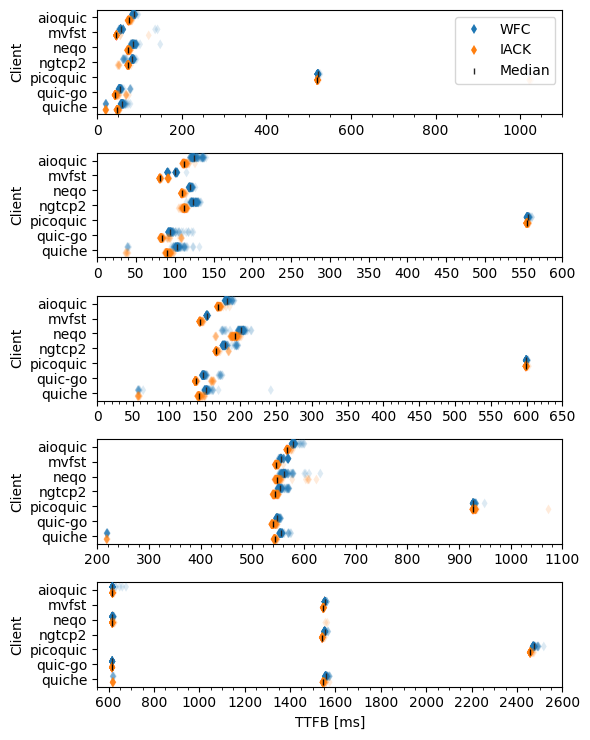

In [34]:
plot.multi(
    lscf_http3,
    group_by="rtt",
    figsize=(6, 1.5 * 5),
    x="time_since_first_ms",
    y="client",
    dest="interop-runner/str_lscf_ttfb_all_latencies_http3cdroplist",
    anc=False,
    legend_pos="upper right",
    sharex=False,
    major=[200, 50, 50, 100, 200],
    minor=[50, 10, 10, 20, 50],
    xlim=[(0, 1100), (0, 600), (0, 650), (200, 1100), (550, 2600)],
    auto_scale_x=False,
)